In [ ]:
"""
Maxwell Zheng (1004907871)
Google Colab Link: https://colab.research.google.com/drive/1YYKnNaH5vi-cxM8D4PDoN8PAkRCe5-gO?usp=sharing
"""

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

In [2]:
def get_relevant_indices(dataset, classes, target_classes):

    indices = []
    for i in range(len(dataset)):
        label_index = dataset[i][1] 
        label_class = classes[label_index]
        if label_class in target_classes:
            indices.append(i)
    return indices

In [3]:
def get_data_loader(target_classes, batch_size):

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    np.random.seed(1000) 
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) 
    
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

In [4]:
def get_model_name(name, batch_size, learning_rate, epoch):

    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

In [5]:
def normalize_label(labels):

    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

In [6]:
def evaluate(net, loader, criterion):

    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [7]:
def plot_training_curve(path):

    import matplotlib.pyplot as plt
    
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [8]:
train_loader, val_loader, test_loader, classes = get_data_loader(target_classes=["cat", "dog"], batch_size=1)

Files already downloaded and verified
Files already downloaded and verified


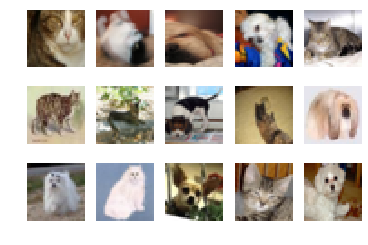

In [10]:
# 1a

import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    image = images[0]
    img = np.transpose(image, [1,2,0])
    img = img / 2 + 0.5
    
    plt.subplot(3,5,k+1)
    plt.axis("off")
    plt.imshow(img)
    
    k += 1
    if k > 14:
        break

In [14]:
#1b

print("Training examples: ", len(train_loader))
print("Validation examples: ", len(val_loader))
print("Testing examples: ", len(test_loader))

Training examples:  8000
Validation examples:  2000
Testing examples:  2000


In [ ]:
#1c

"""
A validation set is required when training our model in order to test it with new sets of data. 
If we judge our model using the training set loss/error instead, we end up overfitting to the training data which 
concludes in false positive results that lead us to misinterpret our accuracy as being high. 
"""

In [11]:
class LargeNet(nn.Module):
    
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) 
        return x

In [12]:
class SmallNet(nn.Module):
    
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) 
        return x

In [13]:
small_net = SmallNet()
large_net = LargeNet()

In [14]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):

    target_classes = ["cat", "dog"]

    torch.manual_seed(1000)

    train_loader, val_loader, test_loader, classes = get_data_loader(target_classes, batch_size)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs): 
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            labels = normalize_label(labels) 
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [15]:
# 2a

print("Small")
for param in small_net.parameters():
    print(param.shape)
    
print("\nLarge")
for param in large_net.parameters():
    print(param.shape)
    
"""
Small Net: 5 groups of 3 3x3 tensors
Large Net: 5 groups of 3 5x5 tensors
"""

Small
torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])

Large
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


In [ ]:
# 2b

"""
Default values:
batch_size: 64
leaning_rate: 0.01
num_epochs: 30
"""

In [ ]:
# 2c

"""
Files written to disk:

1. model_small_bs64_lr0.01_epoch4_train_err.csv
    Info:
    4.359999999999999987e-01
    3.738750000000000129e-01
    3.578749999999999987e-01
    3.483749999999999902e-01
    3.385000000000000231e-01
2. model_small_bs64_lr0.01_epoch4_train_loss.csv
    Info:
    1.058855156600475335e-02
    1.014952868223190259e-02
    9.933517850935458596e-03
    9.757397778332232985e-03
    9.608423233032226812e-03
3. model_small_bs64_lr0.01_epoch4_val_err.csv
    Info
    3.805000000000000049e-01
    3.584999999999999853e-01
    3.524999999999999800e-01
    3.599999999999999867e-01
    3.370000000000000218e-01
4. model_small_bs64_lr0.01_epoch4_val_loss.csv
    Info:
    6.595180425792932510e-01
    6.528661046177148819e-01
    6.263249684125185013e-01
    6.251449063420295715e-01
    6.168369576334953308e-01
"""

In [15]:
train_net(small_net)
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified


..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch 1: Train err: 0.449125, Train loss: 0.6793567218780517 |Validation err: 0.377, Validation loss: 0.6549499128013849
Epoch 2: Train err: 0.368, Train loss: 0.6450611934661865 |Validation err: 0.3745, Validation loss: 0.6568874083459377
Epoch 3: Train err: 0.34575, Train loss: 0.6278857688903808 |Validation err: 0.356, Validation loss: 0.6244987938553095
Epoch 4: Train err: 0.340125, Train loss: 0.6164036607742309 |Validation err: 0.373, Validation loss: 0.635104238986969
Epoch 5: Train err: 0.32575, Train loss: 0.606835533618927 |Validation err: 0.339, Validation loss: 0.6179102789610624
Epoch 6: Train err: 0.317625, Train loss: 0.5963392119407653 |Validation err: 0.3405, Validation loss: 0.6212729215621948
Epoch 7: Train err: 0.312125, Train loss: 0.5933276097774506 |Validation err: 0.327, Validation loss: 0.6039524096995592
Epoch 8: Train err: 0.30975, Train loss: 0.5829582455158233 |Validation err: 0.3235, Validation loss: 0.595826230943203
Epoch 9: Train err: 0.3045, Train loss

In [ ]:
# 2d

"""
Small net: 322.76s
Large net: 362.01s

The large net took longer becuase the tensor is bigger and has more data to compute
"""

Small Net


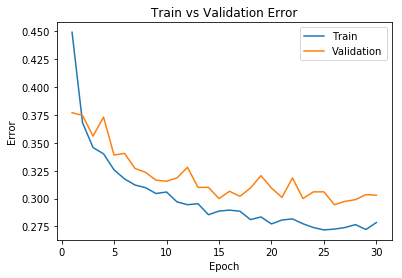

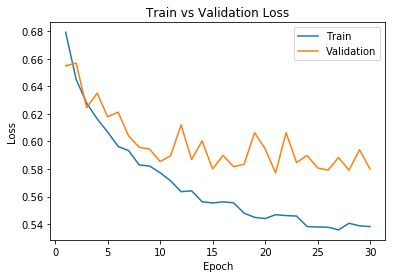

Large Net


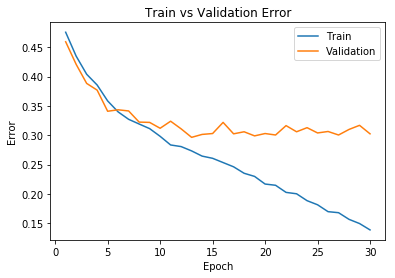

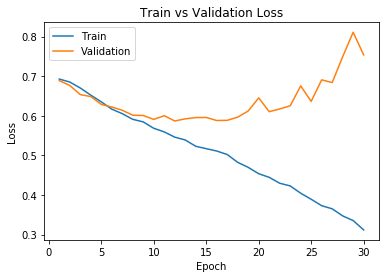

In [16]:
#2e

print("Small Net")
plot_training_curve(get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29))

print("Large Net")
plot_training_curve(get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29))



In [ ]:
#2f

"""
For both nets, the validation curve surpasses the training curve as epochs increase.
Similarly, for both nets, the training curve decreases as epochs increase.
For the small net, the training and validation curve do not differ by much throughout,
indicating that it was trained well.
For the large net, the two curves drastically differ as epochs increase, indicating overfitting of the data.
"""

In [36]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589721679687 |Validation err: 0.4305, Validation loss: 0.6916493400931358
Epoch 3: Train err: 0.43575, Train loss: 0.6916067299842834 |Validation err: 0.4285, Validation loss: 0.6908544469624758
Epoch 4: Train err: 0.43, Train loss: 0.6908614587783813 |Validation err: 0.4245, Validation loss: 0.6896599493920803
Epoch 5: Train err: 0.434375, Train loss: 0.6899197425842285 |Validation err: 0.4195, Validation loss: 0.6886945553123951
Epoch 6: Train err: 0.436, Train loss: 0.6887415976524353 |Validation err: 0.4195, Validation loss: 0.6867831721901894
Epoch 7: Train err: 0.437, Train loss: 0.6873774871826172 |Validation err: 0.4185, Validation loss: 0.6851980295032263
Epoch 8: Train err: 0.4375, Train loss: 0.6859270911216736 |Validation err: 0.411, 

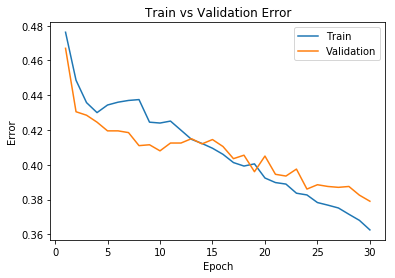

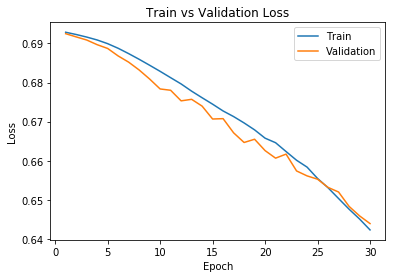

In [43]:
#3a

plot_training_curve(get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29))

"""
Decreasing the learning rate increases the accuracy of the model.
There is very little overfitting since the small learning_rate ensures the model
does not overstep. 
It took 390 seconds which is more than the 361 default seconds.
"""

In [23]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6746205673217773 |Validation err: 0.3715, Validation loss: 0.6348042637109756
Epoch 2: Train err: 0.367, Train loss: 0.6385221910476685 |Validation err: 0.3905, Validation loss: 0.6523979343473911
Epoch 3: Train err: 0.35375, Train loss: 0.6229484834671021 |Validation err: 0.33, Validation loss: 0.6042626369744539
Epoch 4: Train err: 0.322375, Train loss: 0.598579639673233 |Validation err: 0.336, Validation loss: 0.6141789713874459
Epoch 5: Train err: 0.3275, Train loss: 0.6017990653514862 |Validation err: 0.3145, Validation loss: 0.5917556267231703
Epoch 6: Train err: 0.311, Train loss: 0.574092092514038 |Validation err: 0.311, Validation loss: 0.5996946590021253
Epoch 7: Train err: 0.302625, Train loss: 0.571528254032135 |Validation err: 0.344, Validation loss: 0.6356577817350626
Epoch 8: Train err: 0.293125, Train loss: 0.5597186875343323 |Validation err: 0.343, Vali

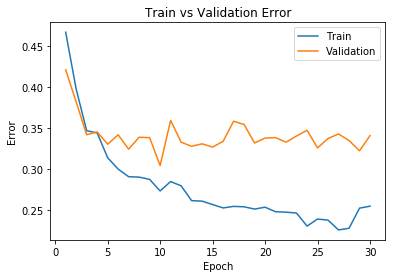

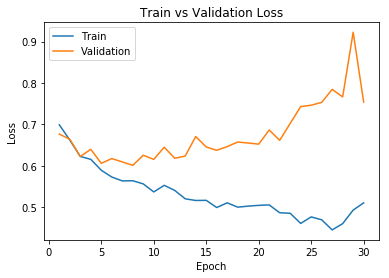

In [21]:
#3b

plot_training_curve(get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29))

"""
Decreasing the learning rate to 0.1 causes the two curves to dramatically differ as 
epochs increases. It starts relatively close but difers very fast.
This took 359 seconds to train which is about the same as the default 361 seconds.
"""

In [28]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49775, Train loss: 0.6936571151018143 |Validation err: 0.5085, Validation loss: 0.6936363279819489
Epoch 2: Train err: 0.490125, Train loss: 0.6921021714806557 |Validation err: 0.468, Validation loss: 0.6915159821510315
Epoch 3: Train err: 0.45975, Train loss: 0.690516397356987 |Validation err: 0.437, Validation loss: 0.6899198740720749
Epoch 4: Train err: 0.440375, Train loss: 0.6888148263096809 |Validation err: 0.431, Validation loss: 0.6879072040319443
Epoch 5: Train err: 0.435375, Train loss: 0.6862181983888149 |Validation err: 0.4415, Validation loss: 0.6851570904254913
Epoch 6: Train err: 0.43725, Train loss: 0.683882649987936 |Validation err: 0.44, Validation loss: 0.6822973340749741
Epoch 7: Train err: 0.434, Train loss: 0.6816304698586464 |Validation err: 0.435, Validation loss: 0.6801079213619232
Epoch 8: Train err: 0.431, Train loss: 0.679784495383501 |Validation err: 0.4285, Va

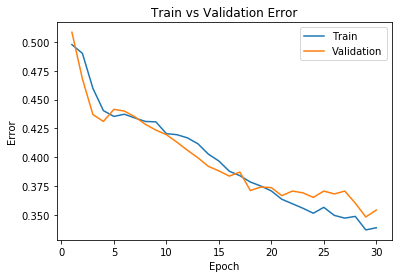

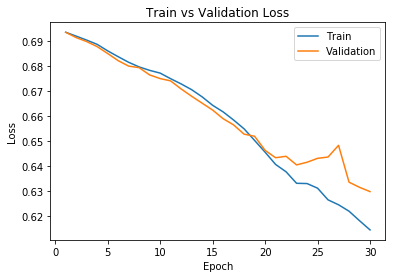

In [33]:
# 3c

plot_training_curve(get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29))

"""
Increasing the batch size makes the model significantly more accurate.
The curves almost overlap for a majority of the time.
There is some overfitting in both graphs as epochs increase greatly.
It took 360 seconds which is close to the default 361 seconds.
"""

In [32]:
large_net = LargeNet()
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4325, Train loss: 0.6775569206476212 |Validation err: 0.3805, Validation loss: 0.6514393572807312
Epoch 2: Train err: 0.366875, Train loss: 0.6393650796413421 |Validation err: 0.3515, Validation loss: 0.6193019015789032
Epoch 3: Train err: 0.339375, Train loss: 0.6140850163698196 |Validation err: 0.345, Validation loss: 0.6353736629486084
Epoch 4: Train err: 0.312875, Train loss: 0.5883884517550468 |Validation err: 0.3345, Validation loss: 0.6016695103645324
Epoch 5: Train err: 0.306875, Train loss: 0.5702615648508071 |Validation err: 0.3055, Validation loss: 0.5741094744205475
Epoch 6: Train err: 0.284375, Train loss: 0.5481644078493119 |Validation err: 0.3045, Validation loss: 0.5877633414268494
Epoch 7: Train err: 0.270875, Train loss: 0.5304309741258622 |Validation err: 0.3125, Validation loss: 0.5884520916938781
Epoch 8: Train err: 0.26225, Train loss: 0.5158911749720574 |Validation e

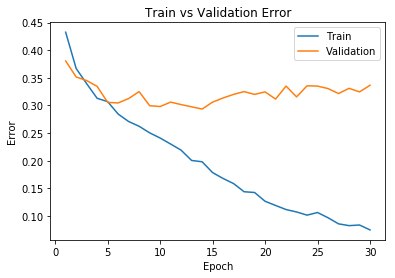

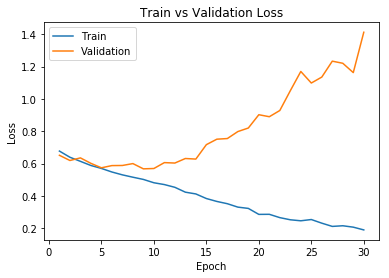

In [35]:
# 3d

plot_training_curve(get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29))

"""
Decreasing batch size seems to make the model significantly less accurate.
The validation curve is much greater than the training curve as epoch increases. 
It took  seconds 410 seconds which is more than the default 361 seconds.
"""


In [ ]:
# 4a

"""
Based upon the above results, two hyperparameters I would choose is a large batch size and a small learning rate. 
I will choose batch_size = 512 and learning_rate = 0.001
In 3c and 3d it is clear tha a larger batch size is advatageous. In 3a and 3b it is clear that a smaller learning rate
yields better results.
"""

In [44]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677480995655 |Validation err: 0.4955, Validation loss: 0.6931362003087997
Epoch 2: Train err: 0.483125, Train loss: 0.6929955147206783 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280385375023 |Validation err: 0.493, Validation loss: 0.6929539293050766
Epoch 4: Train err: 0.477, Train loss: 0.6928808428347111 |Validation err: 0.4885, Validation loss: 0.6928706765174866
Epoch 5: Train err: 0.473375, Train loss: 0.6927744261920452 |Validation err: 0.4835, Validation loss: 0.6927504688501358
Epoch 6: Train err: 0.469, Train loss: 0.6926896125078201 |Validation err: 0.472, Validation loss: 0.6926551759243011
Epoch 7: Train err: 0.46325, Train loss: 0.692620363086462 |Validation err: 0.47, Validation loss: 0.6925524920225143
Epoch 8: Train err: 0.46225, Train loss: 0.6925435662269592 |Validation err: 0.463,

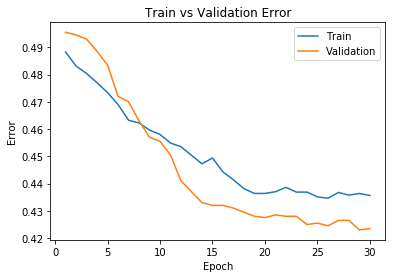

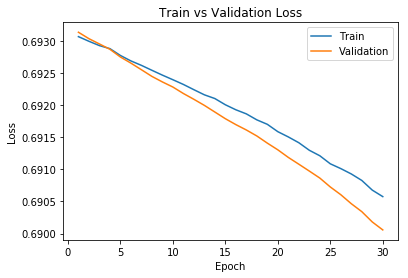

In [45]:
# 4b

plot_training_curve(get_model_name("large", batch_size=512, learning_rate=0.001, epoch=29))

In [42]:
# 4c

"""
It seems the previous test was not as successful as the tests conducted in part 3.
I will slightly increase the learning_rate since it doesn not matter if it oversteps a bit since the 
validation curve is much less than the training curve as epoch increases.
I will choose batch_size=512 and learning_rate=0.005
"""

In [46]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.005, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.486125, Train loss: 0.6930099874734879 |Validation err: 0.4925, Validation loss: 0.6929330825805664
Epoch 2: Train err: 0.474625, Train loss: 0.6927304901182652 |Validation err: 0.46, Validation loss: 0.6924418210983276
Epoch 3: Train err: 0.453875, Train loss: 0.6923641823232174 |Validation err: 0.4385, Validation loss: 0.6920484602451324
Epoch 4: Train err: 0.447625, Train loss: 0.6920197680592537 |Validation err: 0.4325, Validation loss: 0.6916169971227646
Epoch 5: Train err: 0.43625, Train loss: 0.69157699868083 |Validation err: 0.427, Validation loss: 0.6910789608955383
Epoch 6: Train err: 0.436, Train loss: 0.6911382079124451 |Validation err: 0.4275, Validation loss: 0.690511092543602
Epoch 7: Train err: 0.439875, Train loss: 0.690668486058712 |Validation err: 0.427, Validation loss: 0.6898612678050995
Epoch 8: Train err: 0.44375, Train loss: 0.6901450231671333 |Validation err: 0.429

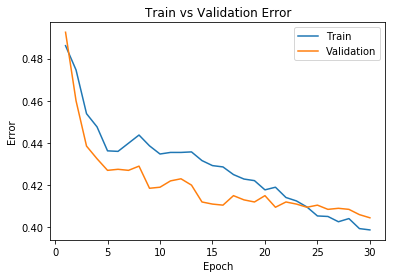

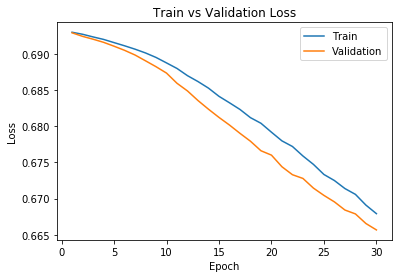

In [47]:
# 4d

plot_training_curve(get_model_name("large", batch_size=512, learning_rate=0.005, epoch=29))


In [50]:
# 5a

net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.005, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

In [ ]:
# 5b

"""
Large net was chosen because the accuracy is maintained at higher epoch levels unlike small net.
Batch_size is 512 since a higher batch_size yields better results.
The learning_rate is less than the default 0.01 since a small learning_rate will ensure it doesn't over step
and cause an overfitting in the training data.
Epochs was left at 30 to ensure training runtime does not take too long and for consistency with all previous tests. 
"""

In [51]:
# 5c

train_loader, val_loader, test_loader, classes = get_data_loader(target_classes=["cat", "dog"], batch_size=512)
evaluate(net, test_loader, nn.BCEWithLogitsLoss())

"""
39.15% error
"""

Files already downloaded and verified
Files already downloaded and verified


(0.3915, 0.6612915396690369)

In [52]:
# 5d

evaluate(net, val_loader, nn.BCEWithLogitsLoss())

"""
Validation error is 40%. 
Since the data has few samples, there will be more error in the model because the data does not fit as well.
"""

(0.4045, 0.6653818190097809)

In [ ]:
# 5e

"""
It is vital that the test data is the last set of data used to run the model. 
We cannot use test data as sample data before ensuring that the model is working and accurate or 
else it will overfit the data. This will result in many false positive data points. 
For this very purpose, we have training and validation data sets in conjunction with the test data sets 
to ensure the model is working in order to run the test data on it.
"""

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt 
import torch.optim as optim

torch.manual_seed(1)

class MNISTClassifier(nn.Module):
    
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(32 * 32, 50)
        self.layer2 = nn.Linear(50, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = self.layer2(activation1)
        return activation2

model = MNISTClassifier()

In [56]:
def get_accuracy(model, train=False):
    
    train_loader, val_loader, test_loader, classes = get_data_loader(target_classes=["cat", "dog"], batch_size=64)
    if train:
        data = train_loader
    else:
        data = val_loader

    correct = 0
    total = 0
    for imgs, labels in data:
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [57]:
def train(model, data, batch_size=64, num_epochs=30):

    train_loader, val_loader, test_loader, classes = get_data_loader(target_classes=["cat", "dog"], batch_size=64)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    n = 0 
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            out = model(imgs)             
            loss = criterion(out, labels) 
            loss.backward()              
            optimizer.step()              
            optimizer.zero_grad()         

            iters.append(n)
            losses.append(float(loss)/batch_size)             
            train_acc.append(get_accuracy(model, train=True)) 
            val_acc.append(get_accuracy(model, train=False))  
            n += 1

    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [62]:
# 5f

train(model, train_loader, batch_size=512, num_epochs=30)
get_accuray(model, train=True)

"""
For the most part, ANN is slower than CNN becuase CNN filters much faster 
due to the colvolution and pooling layers.
"""